# (Very)-Basic Machine learning classifier to detect ICMP attacks.

In [105]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import os
import collections

from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import roc_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
os.chdir('docs_data/DDOS_Detection/dataset')

In [3]:
#we only ICMP dataset
df = pd.read_csv('revised_icmp_dataset.csv').drop('Unnamed: 0',axis=1)

In [4]:
#Don't kill me - non optimal af
#remove the final dot.
y_ = df['result'].apply(lambda x: x[:-1])
 
#icmp_df.isnull().sum()
#none of the values in dataset are null

Here are the type of attacks we can find in the dataset :

PoD : A ping of death is a type of attack on a computer system that involves sending a malformed or otherwise malicious ping to a computer.

Ip-Sweep : Description. Configure the device to detect and prevent an IP Sweep attack. An IP Sweep attack occurs when an attacker sends ICMP echo requests (pings) to multiple destination addresses. If a target host replies, the reply reveals the target's IP address to the attacker.

Smurf : The Smurf attack is a distributed denial-of-service attack in which large numbers of Internet Control Message Protocol packets with the intended victim's spoofed source IP are broadcast to a computer network using an IP broadcast address.

Snmp Guessing : SNMP reflection, like other reflection attacks, involves eliciting a flood of responses to a single spoofed IP address. During an SNMP reflection attack, the perpetrator sends out a large number of SNMP queries with a forged IP address (the victim’s) to numerous connected devices that, in turn, reply to that forged address. This is a volumetric DDoS.

Multi-hop : Multi-vectors, mix of attacks below.

### Extremely basic pre-processing functions
1. Label Binarizer
2. Remove network constants

In [22]:
def binarize_label(attack_type):
    if attack_type == 'normal':
        return 0
    else:
        return 1
    
def pre_processing(df):
    #Remove useless variables, 
    #i.e those who can't take more than one value.
    list_to_drop = []
    
    for variable in df.columns:
        len_ = len(df[variable].unique())
        #print(len_)
        if len_ == 1:
            list_to_drop.append(variable)
            
    df = df.drop(list_to_drop,axis=1)
    
    #categorical variable encoding
    enc_cols = pd.get_dummies(df['service'], drop_first=True)
    # merge with main df bridge_df on key values
    df_ = df.join(enc_cols)
    df_filtered = df_.drop(['service'], axis=1)
    return df_filtered

In [47]:
X_ = pre_processing(df).drop(['result'], axis=1) #Keep data_frame type for correlation analysis
y = y_.apply(lambda x: binarize_label(x))

## Non-discriminant approach

We only use two labels, we don't want to actually what type of attack it but only mitigate any unusual network activity. We drop highly-correlated columns (or anti-correlated).

In [124]:
# Select upper triangle of correlation matrix
corr = X_.corr()

upper = corr.where(np.triu(np.ones(corr.shape),
                                  k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.80 in absolute value.
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.8)]
print(); print(to_drop)

# Drop Marked Features
X_nocorr = X_.drop(to_drop, axis=1)
print(); print(X_nocorr.columns)


['srv_count', 'same_srv_rate', 'una1', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate']

Index(['src_bytes', 'wrong_fragment', 'count', 'serror_rate',
       'srv_diff_host_rate', 'una2', 'dst_host_count', 'dst_host_srv_count',
       'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
       'dst_host_serror_rate', 'dst_host_rerror_rate', 'ecr_i', 'tim_i',
       'urp_i'],
      dtype='object')


* srv_count :	number of connections to the same service as the current connection in the past two seconds 
* same_srv_rate : % of connections to the same service 
* una1 : If connection comes from unauthorized sth? Not sure.
* srv_diff_host_rate : % of connections to different hosts 
* dst_host_same_src_port_rate : % of connections to same port

## Spot-Check Algorithms

In [125]:
X = X_nocorr.values
Y = y.values

In [54]:
import warnings
warnings.filterwarnings("ignore")

In [148]:
validation_size = 0.20 
seed = 7

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed, stratify=y)

# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis())) 
models.append(('KNN', KNeighborsClassifier())) 
models.append(('CART', DecisionTreeClassifier())) 
models.append(('NB', GaussianNB())) 
models.append(('SVM', SVC()))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='balanced_accuracy') 
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.957269 (0.013226)
LDA: 0.948052 (0.023137)
KNN: 0.977191 (0.018519)
CART: 0.988232 (0.015313)
NB: 0.998492 (0.000229)
SVM: 0.791572 (0.026388)


## Decision tree 

In [152]:
#basic decision tree
model = DecisionTreeClassifier(criterion='gini', max_depth=3)

# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, Y, test_size=0.5, random_state=2)

model.fit(trainX, trainy)

# predict probabilities
yhat = model.predict(testX)

for row_index, (input, prediction, label) in enumerate(zip(testX, yhat, testy)):
      if prediction != label and label==1:
        print('row', row_index, 'has been classified as ', prediction, 'and should be ', label)

print()
print('This would need further analysis but it is Friday night')

row 1011 has been classified as  0 and should be  1
row 10761 has been classified as  0 and should be  1
row 27730 has been classified as  0 and should be  1
row 32900 has been classified as  0 and should be  1
row 35275 has been classified as  0 and should be  1
row 59682 has been classified as  0 and should be  1
row 75706 has been classified as  0 and should be  1

This would need further analysis but it is Friday night


## Basic feature-importance analysis

In [114]:
print('We only keep features with more 0.10 in terms of Gini importance index')
print()
for name, importance in zip(X_nocorr.columns, model.feature_importances_):
    if importance > 0.10:
        print(name, "=", importance)

We only keep features with more 0.10 in terms of Gini importance index

count = 0.2523691590690816
dst_host_count = 0.2901766858995995
dst_host_srv_count = 0.45745415503131903


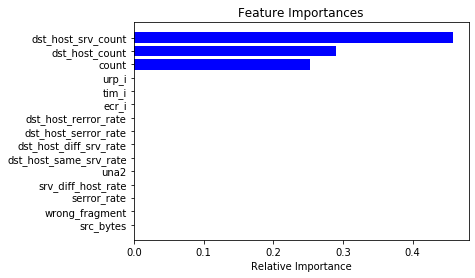

In [115]:
features = X_nocorr.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

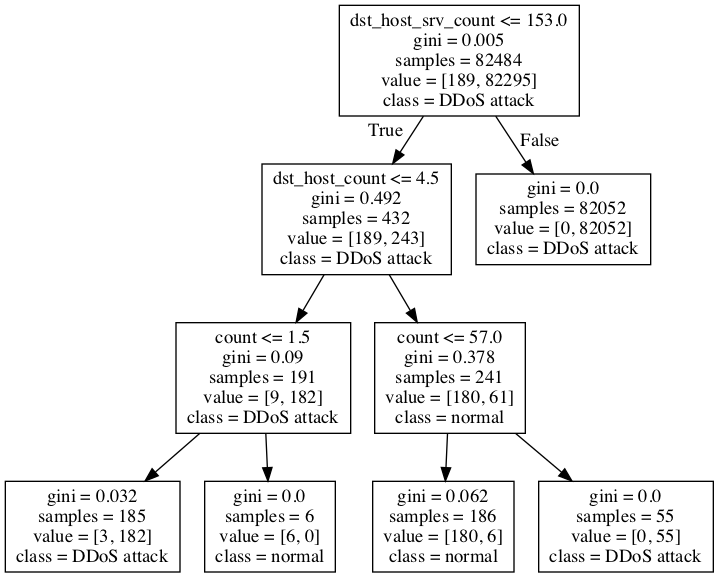

In [116]:
from sklearn.tree.export import export_graphviz
from sklearn import tree
from IPython.display import Image

import pydotplus

# Create DOT data
dot_data = tree.export_graphviz(model, out_file=None, 
                                feature_names=features,  
                                class_names=['normal','DDoS attack'])

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())